# Salary and Hall Of Fame Analysis

<i><p> In this notebook, I'll be analyzing players in the hall of fame dataset (which includes players who have been inducted, have recieved votes, or have been eligible for BBWAA consideration at some point) and merging the salary dataset to examine Hall of Fame player salaries and other characteristics of both datasets. I will also explore the top salaried HOF players by using the MLB Data API. To get players full names for the API search(need in order to not get multiple query results), I will use the sqlite database ( lahmans ) to acquire the players first and last name by merging on the playerID in the salary and HOF datasets. Once I have the full name of top-salaried or HOF players I will pass them into the API player Info endpoint in the MLB Data API to see stats such as position, batting_type, etc. </p> </i>

#### Load modules

In [1]:
import pandas as pd
import numpy as np
import requests
import seaborn as sb
import matplotlib.pyplot as plt
import sqlite3
import altair as alt

#### Reading in Files 

In [2]:
sal_df=pd.read_csv("Salaries.csv")

hall_df=pd.read_csv("HallOfFame.csv")

## Salary and HOF

<i><h3> Average Salary of each player whos has recieved votes, has been in the running to be inducted, or has been inducted into the hall of fame</h3> </i>

In [4]:
sal_df[sal_df['playerID']=='bondsba01']['salary'].mean() ##bbonds average salary

sal_df.groupby('playerID').agg({'salary':np.mean}).astype(int).sort_values(by='salary',ascending=False).head(15)

# highest avg salaries in dataset


,salary
playerID,
tanakma01,22000000
rodrial01,17972202
howarry01,15525500
teixema01,14703846
jeterde01,13927268
sabatcc01,13831632
fieldpr01,12891450
kurodhi01,12580817
linceti01,12444375


In [5]:
# merging salary and hallOfFame dataframes on playerID using inner join. Inner Join gives us intersection of data 
## (i.e, playerID must be in both dataframes)
in_merge = sal_df.merge(hall_df,how='inner',on='playerID')

# grouping on playerID, and getting sum of players salaries and votes
hall_sals=in_merge.groupby('playerID').agg({'salary':sum,'votes':sum})

hall_sals 

# this is the total amount of money earned, and the total votes that each player has recieved 
## (players in both HOF and salary dataset)

,salary,votes
playerID,,
abbotji01,12960500,117.0
aguilri01,32587999,45.0
alexado01,3725000,0.0
alomaro01,153207630,14720.0
alomasa02,28450000,272.0
...,...,...
younger01,29452500,14.0
yountro01,17700000,3465.0
zahnge01,550000,0.0


### Average salary of all players in Salary and HOF dataset

,salary
yearID,
2011.0,2784505291
2012.0,2932741192
2013.0,3034525648
2014.0,3192317623
2015.0,3514142569


<AxesSubplot:xlabel='yearID', ylabel='salary'>

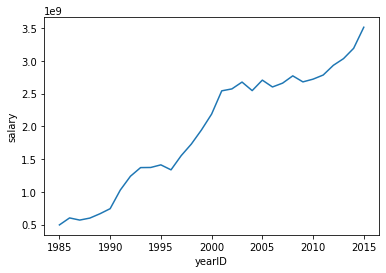

In [6]:
# merge salary and hallOfFame dataframes on playerID using outer join. Gives us the union of dataframes
## (i.e, all playerID's and their data). Some players will not have all data if not in both dataframes
outer_j=sal_df.merge(hall_df,how='outer',on='playerID')

# grouping by yearID and summing the salary for each year
sal_ovr_time=outer_j.groupby('yearID').agg({'salary':sum})

# setting salary column values as integers
sal_ovr_time['salary']=sal_ovr_time['salary'].astype(int)

display(sal_ovr_time.tail())

# lineplot of data with x-axis as yearID and y-axis as Salary
sb.lineplot(data=sal_ovr_time,x='yearID',y='salary') 

# can see salary has been steadily incresasing since 1985 across all players with salary data from both datasets
## (salary is in scientific ( millions ))

### Percent of inducted players / external validation

In [7]:
inducted=outer_j[outer_j['inducted']=='Y']

print(len(inducted['playerID'].unique()))

print(str(round(len(inducted['playerID'].unique()) / len(outer_j)*100,2)) + 
      "% of players have been inducted into hall of fame") 

# less than a percent of players in the dataset have been inducted into the hall of fame (from the hall_df)

312
0.97% of players have been inducted into hall of fame


https://baseballhall.org/discover-more/stories/hall-of-famer-facts/hall-of-famers-by-position

This source confirms that of the 19,000+ players who have played in the MLB only 235 have been elected (a rate of roughly 1%). After adding the 29 Negro League players and the 69 managers, umpires, and executives, the total # of elected members in the hall of fame comes to 333. Our dataset has 21 less members as the dataset is not fully up to date.

In [8]:
print(f'{333/len(outer_j)*100:.2f}%') 

# 333 is roughly 1% of our dataset, if we had fully up-to date data it should decrease

1.04%


### Hall of fame players salaries year-over-year

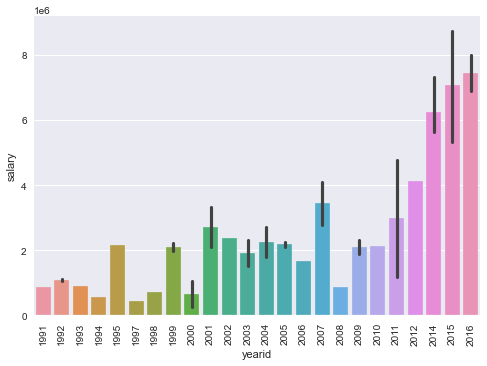

In [219]:
## Many players inducted into hall of fame dont have salary information (players from 1936-1991)

induc_means = inducted.groupby('playerID').agg({'salary':np.mean,'yearid':np.max,'votes':np.mean}).dropna()
mean_df = induc_means.astype(int)
mean_df.sort_values(by='salary',ascending=False)


## pedro martinez had the highest average salary, and was inducted into the hall of fame in 2015

## The highest salaries come from the most recent hall of fame inductees (as expected)

plt.xticks(rotation=90)
sb.barplot(data=mean_df,x='yearid',y='salary')
plt.show()

# highest salaries come from 2015-16, with some spikes across the years (why is this ?)

In [10]:
display(induc_means[induc_means['yearid']==2008])

# some of the spikes in our visual above are from years where only 1 or a couple of players were inducted into the HOF

sal_df[sal_df['playerID']=='gossari01']
# richard gossages mean salary was heavily influenced by his salary in his late years, 
## which caused the low spike in 2008 

,salary,yearid,votes
playerID,,,
gossari01,865504.285714,2008.0,466.0


,yearID,teamID,lgID,playerID,salary
431,1985,SDN,NL,gossari01,1713333
1133,1986,SDN,NL,gossari01,1046761
1806,1987,SDN,NL,gossari01,1273904
2055,1988,CHN,NL,gossari01,1331532
3182,1989,SFN,NL,gossari01,68000
5352,1992,OAK,AL,gossari01,300000
6247,1993,OAK,AL,gossari01,325000


### Votes needed over the years to be inducted into HOF

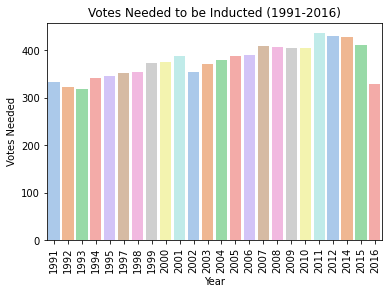

In [11]:
year_group=inducted.groupby('yearid').mean().dropna().reset_index().astype(int)


plt.xticks(rotation=90)
sb.barplot(data=year_group, x='yearid',y='needed', palette='pastel').set(xlabel='Year', 
                                            ylabel='Votes Needed', title='Votes Needed to be Inducted (1991-2016)')
plt.show()

## interesting to see how the number of votes required to get inducted into the hall of fame has varied year-over-year
## as the number of members on the BBWAA (Baseball Writers Association of America) changes.

## Looking at top paid players positions

##### Getting portion of players ID for API request (The API endpoint either takes an integer ID (which I don't have yet) or a a first/last name). I dont have the first name, so I'll search by players by last name (won't be fully accurate). 

In [206]:
# grouping salaries by playerID and getting mean of all columns, sorting by ascending salaries
grouped_sals = sal_df.groupby('playerID').mean().sort_values(by='salary',ascending=False).reset_index()

# changing salaries to ints
grouped_sals['salary'] = grouped_sals['salary'].astype(int)

## to run an api request, we are gonna need some portion of the players last or first name. I'll take all
## the letters in the playerID except the last 4 (which are the first two letters of first name and some #)
highest_sal = grouped_sals['playerID'].str[:-4:]

# grabbing id of top paid player
for i in highest_sal.head(1):
    id_search = i

print(id_search)
print()

# we now have all letters the csv will give us for the last name

# new api request from player info endpoint, using id from previous api call
rq = requests.get("http://lookup-service-prod.mlb.com/json/named.search_player_all.bam?sport_code='mlb'&name_part='"
                  +id_search+"%25'").json()
          
print(rq)
# we can see Masahiro Tanaka (the highest paid player) is not in the mlb data api, we can see this as our queryResults
## only returned 1, and the player is Kensuke Tanaka

# iterating through the search player all dict in the request
for i in [rq['search_player_all']]:
    # setting id equal to players id
    id_ = (i['queryResults']['row']['player_id'])
    

# WE CAN SEE THAT THIS DOESN'T ACTUALLY WORK, AS WE GOT MULTIPLE RESULTS, AND THE FIRST RESULT IS KENSUKE TANAKA,
## NOT MASAHIRO TANAKA

tanak

{'search_player_all': {'copyRight': ' Copyright 2021 MLB Advanced Media, L.P.  Use of any content on this page acknowledges agreement to the terms posted here http://gdx.mlb.com/components/copyright.txt  ', 'queryResults': {'created': '2021-12-01T03:53:09', 'totalSize': '2', 'row': [{'position': 'LF', 'birth_country': 'Japan', 'weight': '170', 'birth_state': '', 'name_display_first_last': 'Kensuke Tanaka', 'college': '', 'height_inches': '9', 'name_display_roster': 'Tanaka', 'sport_code': 'mlb', 'bats': 'L', 'name_first': 'Kensuke', 'team_code': 'sfn', 'birth_city': 'Fukuoka', 'height_feet': '5', 'pro_debut_date': '2013-07-09T00:00:00', 'team_full': 'San Francisco Giants', 'team_abbrev': 'SF', 'birth_date': '1981-05-20T00:00:00', 'throws': 'R', 'league': 'NL', 'name_display_last_first': 'Tanaka, Kensuke', 'position_id': '7', 'high_school': 'Higashi Fukuoka, JPN', 'name_use': 'Kensuke', 'player_id': '547887', 'name_last': 'Tanaka', 'team_id': '137', 'service_years': '', 'active_s

TypeError: list indices must be integers or slices, not str

<i> <h4> This didn't work as multiple players have the same last name (can't be fully accurate) <i/> <h4/>
   - must use the sqlite database to get player full name for API request as none of our csv files have full names

In [207]:
import sqlite3

# passing a string pointing to the .sqlite file (established connection to db)
con = sqlite3.connect("lahmansbaseballdb.sqlite")

# grabbing database name
db_name = pd.read_sql("PRAGMA database_list;", con)["name"][0] 

# selecting all tables from database
list_tables = "SELECT * FROM {}.sqlite_master WHERE type='table';".format(db_name) 

# assigning all tables to the lahamns variable, passing in the db connection as parameter
lahmans = pd.read_sql(list_tables , con=con) 

# looking at first 50 tables of db
lahmans[0:50]

,type,name,tbl_name,rootpage,sql
0,table,allstarfull,allstarfull,2,"CREATE TABLE ""allstarfull"" (\n\t""ID"" INTEGER N..."
1,table,appearances,appearances,151,"CREATE TABLE ""appearances"" (\n\t""ID"" INTEGER N..."
2,table,awardsmanagers,awardsmanagers,3436,"CREATE TABLE ""awardsmanagers"" (\n\t""ID"" INTEGE..."
3,table,awardsplayers,awardsplayers,3445,"CREATE TABLE ""awardsplayers"" (\n\t""ID"" INTEGER..."
4,table,awardssharemanagers,awardssharemanagers,3603,"CREATE TABLE ""awardssharemanagers"" (\n\t""ID"" I..."
5,table,awardsshareplayers,awardsshareplayers,3622,"CREATE TABLE ""awardsshareplayers"" (\n\t""ID"" IN..."
6,table,batting,batting,3757,"CREATE TABLE ""batting"" (\n\t""ID"" INTEGER NOT N..."
7,table,battingpost,battingpost,6554,"CREATE TABLE ""battingpost"" (\n\t""ID"" INTEGER N..."
8,table,collegeplaying,collegeplaying,7006,"CREATE TABLE ""collegeplaying"" (\n\t""ID"" INTEGE..."
9,table,divisions,divisions,7282,"CREATE TABLE ""divisions"" (\n\t""ID"" INTEGER NOT..."


In [212]:
# grabbing playerID, and first/last name from people table in SQlite database
name_df = pd.read_sql_query("SELECT playerID, nameFirst, nameLast FROM people", con)

# merging salary and name df on playerID (using inner join - gives us intersection of data)
sal_merged = sal_df.merge(name_df, how='inner', on='playerID')

# grouping on playerID and aggregating on salary (mean)
grouped_sal_merged = sal_merged.groupby('playerID').agg({'salary':np.mean})

# merging the merged dataframe again with the name df in order to get full names of each grouped playerID
salary_and_names = grouped_sal_merged.merge(name_df,how='inner',on='playerID')

# assigning new column in the new dataframe as the full name (first+last name)
salary_and_names['fullName'] = salary_and_names['nameFirst']+" "+salary_and_names['nameLast']

# sorting by salary in descending order
top_sal_players = salary_and_names.sort_values(by='salary',ascending=False)

# selecting full name and salary columns from new dataframe
top_sal_players[['fullName','salary']].head(25) 

# now we have top salaried players in dataset and their full name for API request

,fullName,salary
4385,Masahiro Tanaka,2.200000e+07
3833,Alex Rodriguez,1.797220e+07
2064,Ryan Howard,1.552550e+07
4413,Mark Teixeira,1.470385e+07
2208,Derek Jeter,1.392727e+07
3954,CC Sabathia,1.383163e+07
1385,Prince Fielder,1.289145e+07
2440,Hiroki Kuroda,1.258082e+07
2574,Tim Lincecum,1.244438e+07
2827,Joe Mauer,1.241875e+07


#### Lets look at top 10 players in terms of salary, and compare various stats from an API request such as if they bat lefty, righty, or switch, what league they play in, and their posiiton

In [213]:
ls = []

for i in top_sal_players['fullName'].head(25):
    mlb_req = requests.get("http://lookup-service-prod.mlb.com/json/named.search_player_all.bam?sport_code='mlb'&name_part='"+i+"%25'").json()
    
    # iterating through api request
    for j in [mlb_req]:
        try:
            if int(j['search_player_all']['queryResults']['totalSize']) > 1:
                ls.append(j['search_player_all']['queryResults']['row'][0])
            else:
                ls.append(j['search_player_all']['queryResults']['row'])
        except:
            pass
        
print(len(ls))
print()
print(ls) # now were getting all the correct players and all players are outputting results

# now we have all players in the list
    

25

[{'position': 'P', 'birth_country': 'Japan', 'weight': '218', 'birth_state': '', 'name_display_first_last': 'Masahiro Tanaka', 'college': '', 'height_inches': '3', 'name_display_roster': 'Tanaka', 'sport_code': 'mlb', 'bats': 'R', 'name_first': 'Masahiro', 'team_code': 'nya', 'birth_city': 'Itami', 'height_feet': '6', 'pro_debut_date': '2014-04-04T00:00:00', 'team_full': 'New York Yankees', 'team_abbrev': 'NYY', 'birth_date': '1988-11-01T00:00:00', 'throws': 'R', 'league': 'AL', 'name_display_last_first': 'Tanaka, Masahiro', 'position_id': '1', 'high_school': 'Komazawa University Tomakomai High School, Hokkaido, JPN', 'name_use': 'Masahiro', 'player_id': '547888', 'name_last': 'Tanaka', 'team_id': '147', 'service_years': '', 'active_sw': 'N'}, {'position': 'SS', 'birth_country': 'USA', 'weight': '230', 'birth_state': 'NY', 'name_display_first_last': 'Alex Rodriguez', 'college': '', 'height_inches': '3', 'name_display_roster': 'Rodriguez, A', 'sport_code': 'mlb', 'bats': 'R', 'name_

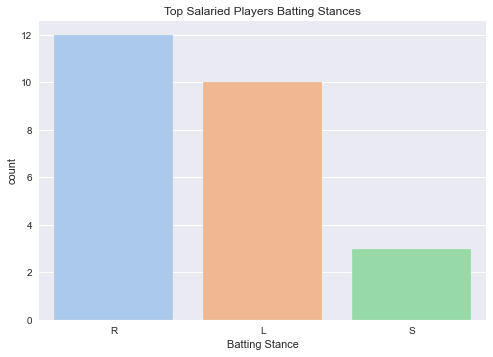

In [218]:
hits=[]


for i in ls:
    hits.append(i['bats'])
    
plt.style.use('seaborn')

bat_L_R = pd.DataFrame({'batting':hits})

sb.countplot(data=bat_L_R, x='batting', palette='pastel').set(title='Top Salaried Players Batting Stances',xlabel='Batting Stance')
plt.show()

## majority of players in top 25 salary list bat righty. 3 players bat switch

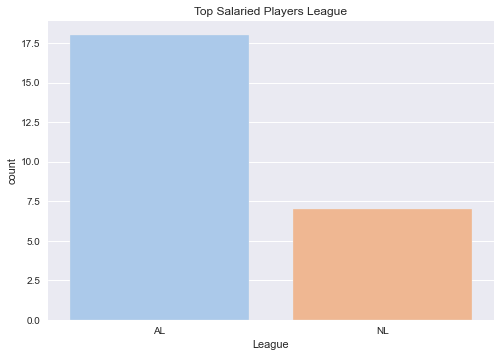

In [223]:
league=[]

for i in ls:
    league.append(i['league'])

players_league = pd.DataFrame({"League":league})

sb.countplot(data=players_league,x='League', palette='pastel').set(title='Top Salaried Players League')

plt.show()

# more players in top 25 salary list play in the AL

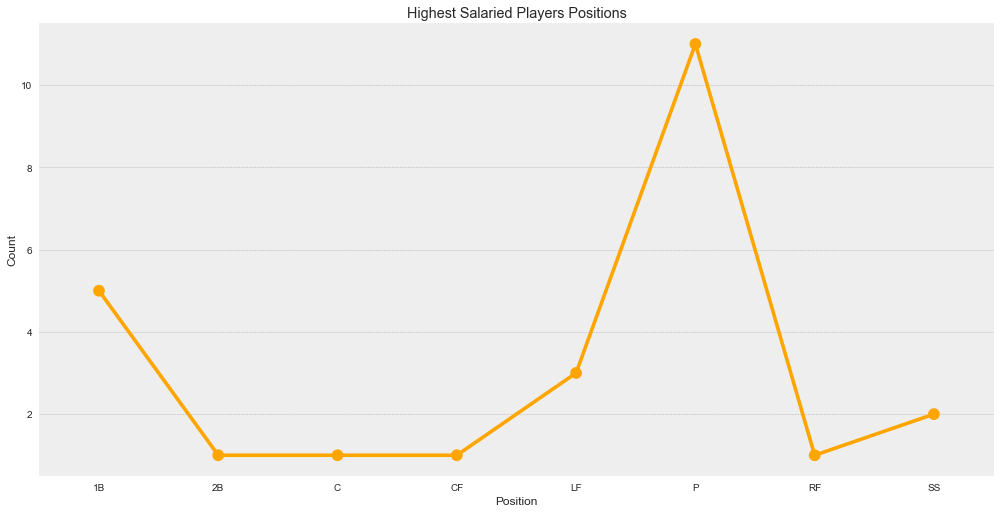

In [239]:
dic_ = {}

for play_ in ls:
    if play_['name_display_first_last'] not in dic_:
        # if player name not in dict then add to the dictioanary and assign the value as the players position
        dic_[play_['name_display_first_last']] = play_['position']

# making a data frame with the dictionary (index 1 makes the player names as all the columns)
play_pos_df = pd.DataFrame(dic_, index=[1])

# transposing the dataframe so the columns (player names) become the values in a new column 
play_pos_df = play_pos_df.transpose().reset_index()

play_pos_df = play_pos_df.rename(columns={'index':'Player',1:'Position'}) # renaming columns

# getting the position value counts and sorting by alphabetical order (as value counts sorts by descending count)
position_counts = play_pos_df['Position'].value_counts().sort_index(ascending=True).reset_index()

# setting plot stle to bmh
plt.style.use('bmh')

# lineplot of the positon_counts data, setting line color to orange and labels/title
sb.catplot(data=position_counts,x='index',y='Position',color='orange',kind='point',aspect=2,
           height=7).set(xlabel='Position',ylabel='Count',title='Highest Salaried Players Positions')

# displaying plot
plt.show()




### can see Pitcher is the most common occurence for the highest paid players (average salary)



### Comparing positions of top salaried players vs. Hall of Fame players

In [162]:
inducted_players = induc_means.merge(name_df,how='inner',on='playerID')
inducted_players['fullName'] = inducted_players['nameFirst']+" "+inducted_players['nameLast']

induc_lis=[]

for i in inducted_players['fullName'].head(25):
    mlb_req = requests.get("http://lookup-service-prod.mlb.com/json/named.search_player_all.bam?sport_code='mlb'&name_part='"+i+"%25'").json()
    
    # iterating through api request
    for j in [mlb_req]:
        try:
            if int(j['search_player_all']['queryResults']['totalSize']) > 1:
                induc_lis.append(j['search_player_all']['queryResults']['row'][0])
            else:
                induc_lis.append(j['search_player_all']['queryResults']['row'])
        except:
            pass
        
        
print(induc_lis)
print()
print(len(induc_lis))



[{'position': '2B', 'birth_country': 'Puerto Rico', 'weight': '190', 'birth_state': '', 'name_display_first_last': 'Roberto Alomar', 'college': '', 'height_inches': '0', 'name_display_roster': 'Alomar', 'sport_code': 'mlb', 'bats': 'S', 'name_first': 'Roberto', 'team_code': 'cha', 'birth_city': 'Ponce', 'height_feet': '6', 'pro_debut_date': '1988-04-22T00:00:00', 'team_full': 'Chicago White Sox', 'team_abbrev': 'CWS', 'birth_date': '1968-02-05T00:00:00', 'throws': 'R', 'league': 'AL', 'name_display_last_first': 'Alomar, Roberto', 'position_id': '4', 'high_school': 'Luis Munoz Rivera, Salinas, PR', 'name_use': 'Roberto', 'player_id': '110183', 'name_last': 'Alomar', 'team_id': '145', 'service_years': '', 'active_sw': 'N'}, {'position': '2B', 'birth_country': 'USA', 'weight': '185', 'birth_state': 'NY', 'name_display_first_last': 'Craig Biggio', 'college': 'Seton Hall', 'height_inches': '11', 'name_display_roster': 'Biggio', 'sport_code': 'mlb', 'bats': 'R', 'name_first': 'Craig', 'team_

### Positions

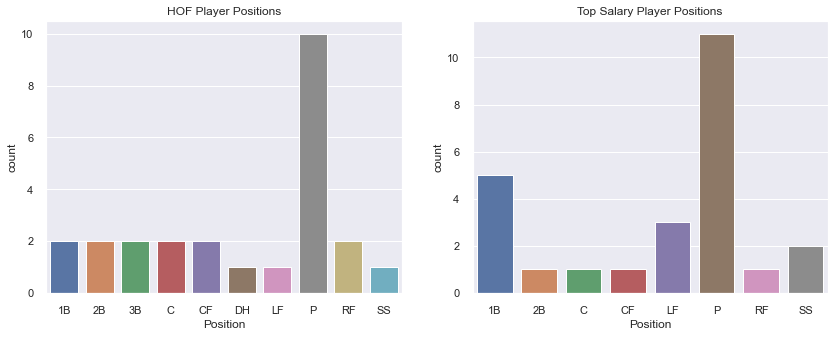

In [245]:
induc_pos = [i['position'] for i in induc_lis]

top_sal_pos = [i['position'] for i in ls]

induc_pos = pd.DataFrame(induc_pos).sort_values(0)

top_sal_pos = pd.DataFrame(top_sal_pos).sort_values(0)

sb.set(rc={'figure.figsize':(14,5)})

fig,(ax1,ax2) = plt.subplots(ncols=2,sharey=False) # used from class, creating subplots in order to display next to each other

sb.countplot(data=induc_pos,x=0,ax=ax1).set(title='HOF Player Positions', xlabel='Position')
sb.countplot(data=top_sal_pos,x=0,ax=ax2).set(title='Top Salary Player Positions',xlabel='Position')

plt.show()
## we can see the positions acorss datasets are fairly similar, but top salaries players have slightly more players
## in 1st base and Pitcher positions, and the top. 25 HOF players have a wider variety of positions


### Height

In [171]:
# putting together player feet and inches for top 25 inducted players and top 25 salaried players to plot 
## distribtions of heights
induc_heights=[float(i['height_feet']+"."+i['height_inches']) for i in induc_lis]
sal_positions = [float(i['height_feet']+"."+i['height_inches']) for i in ls]

25

In [257]:
# creating dataframe with two columns and the positions as the data in the columns
exp = pd.DataFrame({"HOF": induc_heights,
                    "Top Salaried Players": sal_positions})

# passing data in to chart, and using transfrom fold method to  indicate our experiemnt groups and what were measuring
alt.Chart(exp).transform_fold(
    ['HOF', 'Top Salaried Players'],
    as_=['Experiment', 'Measurement']
).mark_area(
    opacity=0.3,
    interpolate='step' # lowering opacity to see both distributions and setting interpolate to step for stepped visual
).encode(
    alt.X('Measurement:Q', bin=alt.Bin(maxbins=25)),# Using height binned as x-axis, setting max to 25 bins
    alt.Y('count()', stack=None), # using count() to get count of each height as y-axis
    alt.Color('Experiment:N') # setting color(similar to hue) as experiment, which also gives us a small legend
).properties(
    title='Distribution of player heights across top salary and HOF players') # setting title with .properties method

## Top Salary players have more of a uniform distribution, 
## while the majortiy of HOF players lie in the 5'6 to 6'1 range
## Top salary players also have more players with greater heights, which is expected as the average height has changed over the years

alt.Chart(...)